# IBM Q Exercise 4: Grover's Algorithm
### Written by Anna Liv Paludan Bjerregaard

In this exercise we get to work with a real quantum-algorithm, that is to say, an algorithm that runs on a quantum computer! Specifically we'll be looking at Grover's algorithm, described in section 12 of the notes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble

from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

We start by constructing a circuit which applies Grover's algorithm to a state of two qubits, meaning that we perform a search on a space with $2^2=4$ possibilities: 00, 01, 10 and 11. Let's say we want our circuit to find the result 11. We encode this into "The Oracle". This might feel like cheating, but remember that this is a search algorithm - when you do a Google search you also have to tell the machine what you're searching for!

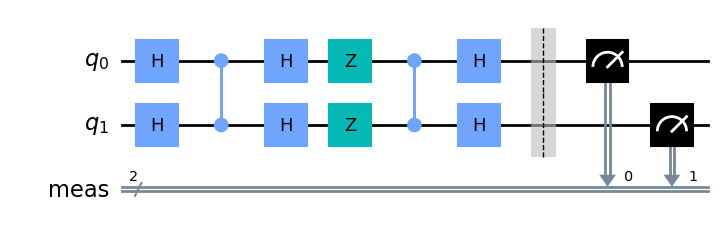

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc
grover_circuit = initialize_s(grover_circuit, [0,1])
#grover_circuit.x(0)#apply to modify oracle
#grover_circuit.x(1)#apply to modify oracle
grover_circuit.cz(0,1) # Oracle
#grover_circuit.x(0)#apply to modify oracle
#grover_circuit.x(1)#apply to modify oracle
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.measure_all()
grover_circuit.draw()

You don't need to understand the diagram, but if you want to you're welcome to try and parse through it!

If the algorithm works as intended it should arrive at the result 11 *every time* we measure. Try running the code below first as a simulation (`sim = True`) and next on a real quantum computer (`sim = False`). Du you expect different results using the two methods?

In [3]:
sim = True
N_measure = 1024

{'|00>': 0, '|10>': 0, '|01>': 0, '|11>': 1024}


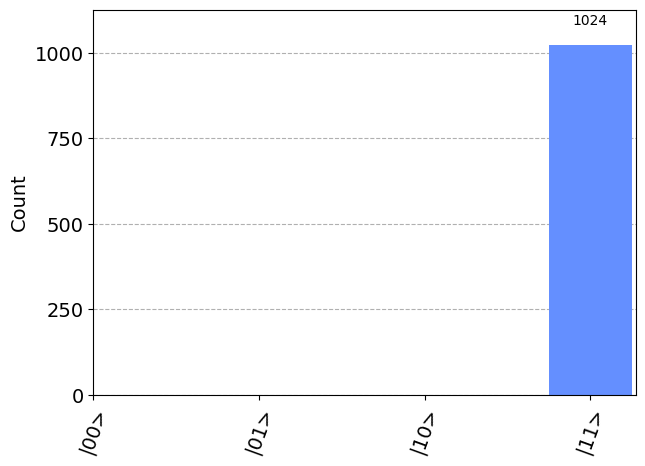

In [4]:
if sim:
    simulator = Aer.get_backend('aer_simulator')
    Nmeasure = N_measure #Amount of times the circuit is run
    result = simulator.run(grover_circuit, shots=Nmeasure).result() 
    device_counts = result.get_counts() #Saves results as dictionary object
    #Simulation code
else:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
    n=3
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
    #Finds the least busy quantum computer on the IBM Q network
    print("least busy backend: ", backend)

# Execute and monitor the job
    from qiskit.tools.monitor import job_monitor
    shots = 1024
    transpiled_circ = transpile(grover_circuit, backend, optimization_level=3) 
    qobj = assemble(transpiled_circ, shots=shots)
    job = backend.run(qobj) #Send circuit to the quantum computer
    job_monitor(job, interval=2)
    device_counts = job.result().get_counts()

possible_measurements = ['00','10','01','11']
measurement_names = ['|00>','|10>','|01>','|11>']

for name, measurement in zip(measurement_names, possible_measurements):
    try:
        device_counts[name] = device_counts.pop(measurement)
    except:
        device_counts[name] = 0

print(device_counts)
plot_histogram(device_counts)

If you had time to try the real quantum computer: How did the result change from the simulation? Why do you think that is?

Now you've tried running a real quantum algorithm!
Through these exercises you've learned

1. What a qubit is

2. How to measure them

3. Entanglement of qubits

4. How to use qubits to make algorithms for quantum computers

and you're well equipped to explore the world of quantum computers further!

**Bonus exercise:** Let's try to run Grover's algorithm on three qubits! This gives us $2^3 = 8$ possibilities. In this example we choose $|111\rangle$ to be our solution and encode it into The Oracle. You can change the variable `n_grover` to control the amount of times Grover's algorithm is applied. Try some different values and see how the result changes! If the wait time is not too long, you can try running the circuit on a quantum computer by setting `sim = False`.

In [5]:
qc = QuantumCircuit(3)
#qc.cz(0, 2)#This and the next line picks |101> and |110>
#qc.cz(1, 2)
qc.h(2)#the ande the following 2 lines picks the |111> state 
qc.ccx(0,1,2)
qc.h(2)

oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

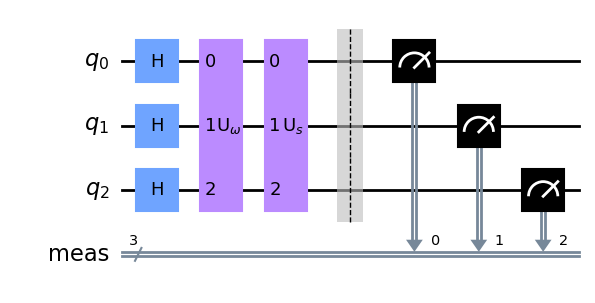

In [6]:
n = 3
n_grover = 1

grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
for i in range(n_grover):
    grover_circuit.append(oracle_ex3, [0,1,2])
    grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

In [7]:
sim = True
N_measure = 1024

{'|000>': 39, '|001>': 39, '|010>': 29, '|011>': 47, '|100>': 41, '|101>': 25, '|110>': 34, '|111>': 770}


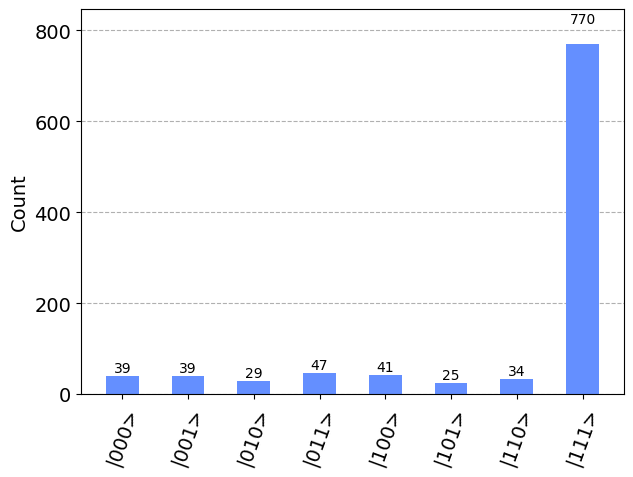

In [8]:
if sim:
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
    qobj = assemble(transpiled_grover_circuit)
    results = aer_sim.run(qobj).result()
    device_counts = results.get_counts()
    #Simulation code
else:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
    n=3
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
    #Finds the least busy quantum computer on the IBM Q network
    print("least busy backend: ", backend)

# Execute and monitor the job
    from qiskit.tools.monitor import job_monitor
    shots = 1024
    transpiled_circ = transpile(grover_circuit, backend, optimization_level=3) 
    qobj = assemble(transpiled_circ, shots=shots)
    job = backend.run(qobj) #Send circuit to the quantum computer
    job_monitor(job, interval=2)
    device_counts = job.result().get_counts()

possible_measurements = ['000','001','010','011','100','101','110','111']
measurement_names = ['|000>','|001>','|010>','|011>','|100>','|101>','|110>','|111>']

for name, measurement in zip(measurement_names, possible_measurements):
    try:
        device_counts[name] = device_counts.pop(measurement)
    except:
        device_counts[name] = 0

print(device_counts)
plot_histogram(device_counts)